# Build a Multi-Agent System With LangGraph

The future of AI isn't about building a smarter chatbot; it's about building a team.

Today, we will build that team using LangGraph. We will create a Multi-Agent System where one AI agent acts as a Researcher (browsing the web), and another acts as a Writer (synthesising that info). They will pass work to each other like colleagues in a newsroom.

If you are a student or a developer looking to break into the Agentic Workflow space, this is the perfect starting point. Let's dive in.

## Learning Objectives

By the end of this notebook, you will be able to:

- Understand the core concepts of LangGraph and multi-agent systems
- Build a state-based workflow with multiple AI agents
- Integrate external tools (web search) with LLMs
- Create a production-ready multi-agent system with error handling
- Visualize and debug agent workflows
- Extend the system with additional agents or capabilities

## Resources and Documentation

- **LangGraph Documentation**: https://langchain-ai.github.io/langgraph/
- **LangChain Documentation**: https://python.langchain.com/
- **Ollama**: https://ollama.com/
- **LangGraph GitHub**: https://github.com/langchain-ai/langgraph


## What is LangGraph?

Before we write code, let's understand what we are building. Imagine a relay race. Runner A has the baton (data). They run their lap (task) and then pass the baton to Runner B. Runner B cannot start until they receive the baton.

**LangGraph** allows us to code this relay race. It's a library for building stateful, multi-actor applications with LLMs. Think of it as a way to create workflows where AI agents can collaborate, make decisions, and pass information between each other.

### Key Concepts

- **Nodes**: These are the agents or functions (The Runners). Each node performs a specific task and can read/write to the shared state.
- **Edges**: These are the rules of who goes next (The Track). They define the flow of execution between nodes.
- **State**: This is the shared memory (The Baton). It's a TypedDict that all nodes can access and modify.

Instead of one giant prompt, we break the logic into small, reliable steps. This approach offers several advantages:

1. **Modularity**: Each agent has a single, well-defined responsibility
2. **Debugging**: You can inspect the state at each step
3. **Scalability**: Easy to add new agents or modify existing ones
4. **Reliability**: Errors in one agent don't crash the entire system

### When to Use LangGraph

LangGraph is ideal for:
- Multi-step reasoning tasks
- Agentic workflows with decision points
- Systems requiring state management
- Complex applications that need to coordinate multiple LLM calls

**Learn More**: 
- [LangGraph Introduction](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [LangGraph Concepts](https://langchain-ai.github.io/langgraph/concepts/)


## The Setup

To keep this accessible and free, we are going to use Ollama to run a local LLM (Llama 3). This means you don't need an OpenAI API key to follow along, though you will need a decent internet connection for the search tool.

### Prerequisites

**1. Python Installation**
- Make sure you have Python 3.9+ installed
- Check your version: `python --version` or `python3 --version`
- Download from: https://www.python.org/downloads/

**2. Ollama Installation**
- Download Ollama from: https://ollama.com/
- Install it on your system
- Verify installation: `ollama --version`

**3. Pull the Llama 3 Model**
- Open your terminal and run: `ollama pull llama3`
- This will download the model (approximately 4.7GB)
- Verify: `ollama list` should show `llama3`

**4. Install Python Dependencies**

Create a virtual environment (highly recommended):
```bash
python -m venv venv
source venv/bin/activate  # On Windows: venv\Scripts\activate
```

Install required packages:
```bash
pip install langgraph langchain langchain-community langchain-core langchain-ollama duckduckgo-search
```

### Alternative: Using OpenAI or Other LLMs

If you prefer to use OpenAI or other cloud-based LLMs, you can replace `ChatOllama` with:
- `ChatOpenAI` from `langchain_openai` (requires API key)
- `ChatAnthropic` from `langchain_anthropic` (requires API key)
- Other providers supported by LangChain

**Note**: The rest of the code will work the same way, just change the LLM initialization.


## Building a Multi-Agent System With LangGraph: Getting Started

We will build this in three parts: **The State**, **The Agents**, and **The Graph**.

### Architecture Overview

Our system will follow this flow:

```
[Start] → [Researcher Agent] → [Writer Agent] → [End]
           (Web Search)         (LLM Generation)
```

1. **The State**: Define what data flows between agents
2. **The Agents**: Create the Researcher and Writer nodes
3. **The Graph**: Wire everything together and define the execution flow

Let's start building!


### Step 1: Defining the Shared State

Think of the AgentState as a shared clipboard that hangs on the office wall. Every agent can read from it and write to it. This ensures that when the Researcher finds something, the Writer can actually see it.

**Why TypedDict?**
- **Type Safety**: Python's type checker can validate your code
- **Documentation**: Clear contract of what data is available
- **IDE Support**: Better autocomplete and error detection
- **Runtime Validation**: LangGraph uses this to ensure state consistency

**Key Points:**
- Each field in the state can be read by any node
- Nodes return dictionaries with only the fields they want to update
- LangGraph automatically merges updates into the state
- The state persists throughout the entire workflow execution

Without a structured state, agents are just shouting into the void. This TypedDict ensures type safety and clarity.


In [1]:
# Import required libraries
from typing import TypedDict, List
from langgraph.graph import StateGraph, END

# ----- Shared State -----
class AgentState(TypedDict):
    """
    The shared state that flows through our multi-agent system.
    
    Fields:
        topic: The research topic provided by the user
        research_data: List of research findings from the Researcher agent
        blog_post: The final blog post generated by the Writer agent
    """
    topic: str
    research_data: List[str]  # A list of findings from web search
    blog_post: str            # The final output generated by the Writer

# Note: TypedDict is a special dictionary type that provides type hints
# while still being a regular dict at runtime. This is perfect for LangGraph!


### Step 2: The Researcher Agent

Our first employee is the Researcher. Their job is simple: take a topic, search DuckDuckGo, and paste the results onto the clipboard (State).

**Design Decision: Why No LLM Here?**

Notice we aren't using an LLM here yet! We are just using a deterministic tool (Search). This approach offers several benefits:

1. **Cost Efficiency**: Web search is free, LLM calls cost money/tokens
2. **Speed**: Search is faster than generating text
3. **Accuracy**: Grounding in real data reduces hallucinations
4. **Reliability**: Deterministic tools are more predictable

**The Researcher's Responsibilities:**
- Extract the topic from the state
- Perform web search using DuckDuckGo
- Handle errors gracefully
- Append results to the research_data list

**DuckDuckGo Search**: 
- Privacy-focused search engine
- No API key required
- Good for general web searches
- Documentation: https://github.com/deedy5/duckduckgo_search


In [2]:
# Import DuckDuckGo search tool
# Note: If this import fails, try: from duckduckgo_search import DDGS
# and use: search = DDGS().text(query, max_results=5)
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
import logging

# Set up logging for better debugging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def researcher_node(state: AgentState) -> dict:
    """
    Researcher agent that searches DuckDuckGo for the latest news and key facts about a given topic.
    
    Args:
        state: The current AgentState containing the topic and existing research_data
        
    Returns:
        dict: Updated state with new research findings appended to research_data
        
    Note:
        This function only returns the fields it wants to update. LangGraph will
        automatically merge this with the existing state.
    """
    # Extract topic from state
    topic = state.get("topic", "")
    
    if not topic:
        logger.warning("No topic provided in state")
        return {"research_data": state.get("research_data", []) + ["Error: No topic provided"]}
    
    logger.info(f"🔍 Researcher is looking up: {topic}...")
    print(f"Researcher is looking up: {topic}...")
    
    # Initialize the search tool
    search = DuckDuckGoSearchRun()
    
    # Perform the search with error handling
    try:
        # Construct the search query
        # You can customize this query format based on your needs
        query = f"key facts and latest news about {topic}"
        logger.info(f"Search query: {query}")
        
        # Execute the search
        results = search.run(query)
        
        # Validate results
        if not results or len(str(results).strip()) == 0:
            results = f"No results found for topic: {topic}"
            logger.warning("Search returned empty results")
        else:
            logger.info(f"Search completed successfully. Results length: {len(str(results))} characters")
            
    except Exception as e:
        # Graceful error handling
        error_msg = f"Search error for topic '{topic}': {str(e)}"
        logger.error(error_msg)
        results = error_msg
        
    print("✅ Research complete.")
    logger.info("Research phase completed")
    
    # Get existing research data or initialize empty list
    existing_research = state.get("research_data", [])
    
    # Return only the fields we want to update
    # LangGraph will merge this with the existing state
    return {
        "research_data": existing_research + [results]
    }


### Step 3: The Writer Agent

Now, the Writer steps in. This agent uses Llama 3 (via Ollama). It reads the research_data found by the previous agent and drafts the content.

**The Writer's Responsibilities:**
- Read the research findings from the state
- Use an LLM to synthesize the information into a blog post
- Follow the prompt template to ensure quality output
- Return the generated blog post

**Understanding Temperature:**
- **Temperature = 0.7**: Balanced creativity and consistency (good for blog posts)
- **Temperature = 0.1**: More deterministic, factual (good for reports)
- **Temperature = 1.0+**: More creative, less consistent (good for creative writing)

**Prompt Engineering Tips:**
- Be specific about the desired output format
- Include constraints (e.g., "based ONLY on the following research data")
- Set the role/context clearly ("You are a tech blog writer")
- Specify length if needed ("short, engaging blog post")

**LangChain Prompt Templates**: 
- Documentation: https://python.langchain.com/docs/modules/model_io/prompts/
- Allows for reusable, parameterized prompts


In [4]:
# Import required libraries
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
import logging

logger = logging.getLogger(__name__)

def writer_node(state: AgentState) -> dict:
    """
    Writer agent that synthesizes research data into a blog post using an LLM.
    
    Args:
        state: The current AgentState containing topic and research_data
        
    Returns:
        dict: Updated state with the generated blog_post
        
    Note:
        This uses ChatOllama to run a local LLM. Make sure Ollama is running
        and the llama3 model is installed.
    """
    logger.info("✍️ Writer is drafting the post...")
    print("Writer is drafting the post...")
    
    # Extract data from state
    topic = state.get("topic", "Unknown Topic")
    research_data = state.get("research_data", [])
    
    # Get the most recent research findings
    # We use [-1] to get the last item, or empty string if list is empty
    data = research_data[-1] if research_data else ""
    
    # Validate that we have research data
    if not data or len(data.strip()) == 0:
        logger.warning("No research data available for writing")
        return {
            "blog_post": f"Error: No research data found for topic '{topic}'. Please ensure the Researcher agent completed successfully."
        }
    
    logger.info(f"Using research data of length: {len(data)} characters")
    
    # Initialize the LLM
    # Note: Make sure Ollama is running and llama3 model is pulled
    try:
        llm = ChatOllama(
            model="llama3",  # You can change this to other models like "llama3.1", "mistral", etc.
            temperature=0.7,  # Controls creativity: 0.0 (deterministic) to 1.0+ (creative)
        )
        logger.info("LLM initialized successfully")
    except Exception as e:
        error_msg = f"Failed to initialize LLM: {str(e)}. Make sure Ollama is running and the model is installed."
        logger.error(error_msg)
        return {"blog_post": error_msg}
    
    # Create the prompt template
    # This template defines the role, task, and constraints for the LLM
    prompt = ChatPromptTemplate.from_template(
        """You are a tech blog writer with expertise in AI and technology trends.

Your task: Write a short, engaging blog post about "{topic}" 
based ONLY on the following research data. Do not make up information.

Research Data:
{data}

Instructions:
- Write in a clear, engaging style
- Use the research data as your source of truth
- Keep it concise (2-3 paragraphs)
- Make it interesting for a tech-savvy audience
- Do not add information not present in the research data

Return just the blog post content, no additional commentary."""
    )
    
    # Create a chain: prompt -> LLM
    # The pipe operator (|) chains components together
    chain = prompt | llm
    
    # Invoke the chain with our data
    try:
        logger.info("Invoking LLM to generate blog post...")
        response = chain.invoke({
            "topic": topic,
            "data": data
        })
        
        # Extract the content from the response
        blog_post = response.content if hasattr(response, 'content') else str(response)
        
        logger.info(f"Blog post generated successfully. Length: {len(blog_post)} characters")
        print("✅ Writing complete.")
        
        return {"blog_post": blog_post}
        
    except Exception as e:
        error_msg = f"Error generating blog post: {str(e)}"
        logger.error(error_msg)
        return {"blog_post": error_msg}


### Step 4: Wiring the Graph

This is the key part. We define the workflow. It is a linear path: Start → Researcher → Writer → End.

**Understanding the Graph Structure:**

1. **StateGraph**: The main class that manages the workflow
2. **add_node()**: Registers an agent/function as a node
3. **set_entry_point()**: Defines where the workflow starts
4. **add_edge()**: Connects nodes in sequence
5. **compile()**: Finalizes the graph and makes it executable

**Graph Flow Visualization:**
```
[START]
   ↓
[Researcher Node] → Searches web, updates research_data
   ↓
[Writer Node] → Generates blog post, updates blog_post
   ↓
[END]
```

**Why This Structure?**
- **Linear Flow**: Simple and predictable
- **Sequential Dependencies**: Writer needs research data first
- **Easy to Extend**: Can add more nodes (e.g., Editor, Fact-Checker)

**Learn More**: 
- [LangGraph Graph Construction](https://langchain-ai.github.io/langgraph/how-tos/graph-construction/)


In [5]:
# ----- Build the LangGraph -----

# Initialize the StateGraph with our AgentState
# This tells LangGraph what the structure of our state should be
workflow = StateGraph(AgentState)

# Add nodes (agents) to the graph
# Each node is a function that receives state and returns updates
workflow.add_node("Researcher", researcher_node)
workflow.add_node("Writer", writer_node)

# Define the execution flow
# Flow: Start → Researcher → Writer → END

# Set the entry point (where execution begins)
workflow.set_entry_point("Researcher")

# Add edges (connections between nodes)
# This defines the order of execution
workflow.add_edge("Researcher", "Writer")  # After Researcher, go to Writer
workflow.add_edge("Writer", END)           # After Writer, end the workflow

# Compile the graph to make it executable
# This validates the graph structure and creates the runnable app
app = workflow.compile()

print("✅ Graph compiled successfully!")
print("\nGraph Structure:")
print("  START → Researcher → Writer → END")


✅ Graph compiled successfully!

Graph Structure:
  START → Researcher → Writer → END


### Step 5: Running the System

Now, let's fire it up! We trigger the `app.invoke()` method with our initial input.

**What Happens When You Run:**

1. **Initialization**: The graph receives the initial state with the topic
2. **Researcher Phase**: 
   - Prints "Researcher is looking up: [topic]..."
   - Searches DuckDuckGo (may take 5-10 seconds)
   - Updates state with research findings
3. **Writer Phase**:
   - Prints "Writer is drafting the post..."
   - Sends research data to LLM (may take 10-30 seconds depending on model)
   - Generates blog post based on research
4. **Completion**: Returns final state with blog_post field populated

**Understanding app.invoke():**
- Takes the initial state as input
- Executes all nodes in sequence according to the graph
- Returns the final state after all nodes complete
- Blocks until the entire workflow finishes

**Alternative: Streaming Execution**
- Use `app.stream()` for real-time updates
- See intermediate states as they're generated
- Useful for long-running workflows


In [7]:
# Prepare the initial state
# This is what we pass to the graph to start execution
print("🚀 Starting the Multi-Agent System...\n")

inputs: AgentState = {
    "topic": "The future of AI Agents",
    "research_data": [],  # Empty initially, will be populated by Researcher
    "blog_post": "",      # Empty initially, will be populated by Writer
}

# Execute the workflow
# This will run all nodes in sequence: Researcher → Writer
print("Executing workflow...")
print("=" * 60)
result = app.invoke(inputs)
print("=" * 60)

# Display the results
print("\n" + "=" * 60)
print("FINAL OUTPUT")
print("=" * 60)
print("\n📝 Generated Blog Post:\n")
print(result["blog_post"])

# Optional: Display the full state for inspection
print("\n" + "=" * 60)
print("FULL STATE (for debugging)")
print("=" * 60)
print(f"\nTopic: {result['topic']}")
print(f"\nResearch Data Entries: {len(result['research_data'])}")
if result['research_data']:
    print(f"Last Research Entry (first 200 chars): {result['research_data'][-1][:200]}...")
print(f"\nBlog Post Length: {len(result['blog_post'])} characters")


INFO:__main__:🔍 Researcher is looking up: The future of AI Agents...
INFO:__main__:Search query: key facts and latest news about The future of AI Agents


🚀 Starting the Multi-Agent System...

Executing workflow...
Researcher is looking up: The future of AI Agents...


INFO:ddgs.ddgs:Error in engine grokipedia: DDGSException("RuntimeError: RuntimeError('error sending request for url (https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=key%20facts%20and%20latest%20news%20about%20The%20future%20of%20AI%20Agents): client error (Connect)\\n\\nCaused by:\\n    0: client error (Connect)\\n    1: dns error: failed to lookup address information: nodename nor servname provided, or not known\\n    2: failed to lookup address information: nodename nor servname provided, or not known')")
INFO:primp:response: https://grokipedia.com/api/typeahead?query=key+facts+and+latest+news+about+The+future+of+AI+Agents&limit=1 200
INFO:primp:response: https://www.mojeek.com/search?q=key+facts+and+latest+news+about+The+future+of+AI+Agents 200
INFO:__main__:Search completed successfully. Results length: 689 characters
INFO:__main__:Research phase completed
INFO:__main__:✍️ Writer is drafting the post...
INFO:__main__:Using research data of length: 

✅ Research complete.
Writer is drafting the post...


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Blog post generated successfully. Length: 1334 characters


✅ Writing complete.

FINAL OUTPUT

📝 Generated Blog Post:

The Future of AI Agents: Revolutionizing Automation

As AI agents become increasingly prevalent in various industries, one question remains: what's next? According to Kirby and Marc Escobosa, VP of Salesforce Futures, the future is bright for agentic AI, particularly as it pertains to small and medium-sized businesses. With the rise of AI-powered automation, these organizations will soon rely on AI agents – whether in the form of chatbots, virtual assistants, or autonomous execution – to streamline operations and stay competitive.

The fundamentals of AI agents are simple: they're intelligent systems that can perform tasks independently, often mimicking human behavior. This agentic approach is poised to transform businesses as we know it, enabling seamless communication between humans and machines. With the ability to handle complex tasks, make decisions, and learn from data, AI agents will revolutionize the way companies opera

## Advanced Topics and Extensions

### Try Different Topics

Experiment with different topics to see how the system adapts:

```python
# Try these topics:
topics = [
    "Quantum computing breakthroughs 2024",
    "Sustainable energy solutions",
    "The impact of AI on healthcare",
    "Space exploration recent discoveries"
]

for topic in topics:
    result = app.invoke({
        "topic": topic,
        "research_data": [],
        "blog_post": ""
    })
    print(f"\n{'='*60}")
    print(f"Topic: {topic}")
    print(f"{'='*60}")
    print(result["blog_post"][:500] + "...\n")
```

### Visualize the Graph

You can visualize your graph structure:

```python
try:
    from IPython.display import Image, display
    # Generate graph visualization
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization requires additional dependencies")
    print("Install with: pip install pygraphviz")
```

### Add More Agents

Consider extending the system with:

1. **Editor Agent**: Reviews and improves the blog post
2. **Fact-Checker Agent**: Validates claims against research
3. **SEO Agent**: Optimizes content for search engines
4. **Summarizer Agent**: Creates a summary version

### Error Handling and Monitoring

For production systems, consider:
- Adding retry logic for failed operations
- Implementing state persistence
- Adding monitoring and logging
- Creating fallback mechanisms

### Conditional Routing

LangGraph supports conditional edges for decision-making:

```python
def should_continue(state):
    if len(state["research_data"]) > 0:
        return "Writer"
    else:
        return "Researcher"  # Retry research

workflow.add_conditional_edges("Researcher", should_continue)
```

## Closing Thoughts

So, this is how to build a Multi-Agent System with LangGraph. Building Multi-Agent systems can feel intimidating. It requires us to stop thinking like users, prompting a box, and start thinking like managers directing a team. 

**Key Takeaways:**

1. **Modularity**: Break complex tasks into specialized agents
2. **State Management**: Use TypedDict for clear data contracts
3. **Error Handling**: Always plan for failures
4. **Extensibility**: Design for easy addition of new agents
5. **Testing**: Test each agent independently before integration

Now, you are no longer limited by what one neural network can hold in its context window. You are orchestrating a system that can browse, think, critique, and refine.

**Next Steps:**
- Experiment with different agent configurations
- Add more sophisticated routing logic
- Integrate with databases or APIs
- Deploy your system as a service
- Explore LangGraph's advanced features like human-in-the-loop

**Resources:**
- [LangGraph Tutorials](https://langchain-ai.github.io/langgraph/tutorials/)
- [LangGraph Examples](https://github.com/langchain-ai/langgraph/tree/main/examples)
- [Multi-Agent Systems Best Practices](https://langchain-ai.github.io/langgraph/how-tos/)


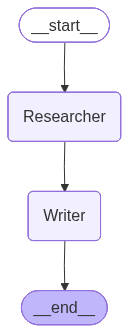

In [8]:
try:
    from IPython.display import Image, display
    # Generate graph visualization
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization requires additional dependencies")
    print("Install with: pip install pygraphviz")

In [9]:
# Example: Test with a different topic
test_topic = "Latest developments in quantum computing"

print(f"Testing with topic: {test_topic}\n")
print("=" * 60)

test_result = app.invoke({
    "topic": test_topic,
    "research_data": [],
    "blog_post": ""
})

print("\n" + "=" * 60)
print("RESULT")
print("=" * 60)
print(test_result["blog_post"])


INFO:__main__:🔍 Researcher is looking up: Latest developments in quantum computing...
INFO:__main__:Search query: key facts and latest news about Latest developments in quantum computing


Testing with topic: Latest developments in quantum computing

Researcher is looking up: Latest developments in quantum computing...


INFO:ddgs.ddgs:Error in engine grokipedia: DDGSException("RuntimeError: RuntimeError('error sending request for url (https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=key%20facts%20and%20latest%20news%20about%20Latest%20developments%20in%20quantum%20computing): client error (Connect)\\n\\nCaused by:\\n    0: client error (Connect)\\n    1: dns error: failed to lookup address information: nodename nor servname provided, or not known\\n    2: failed to lookup address information: nodename nor servname provided, or not known')")
INFO:primp:response: https://grokipedia.com/api/typeahead?query=key+facts+and+latest+news+about+Latest+developments+in+quantum+computing&limit=1 200
INFO:primp:response: https://search.yahoo.com/search;_ylt=m8NyDD3XVum0789KTaJUSNlR;_ylu=fQTMJsl_7Vp0-YQ2WhIlHqiiO5ZxsGttG-IcWGPAlHVhIek?p=key+facts+and+latest+news+about+Latest+developments+in+quantum+computing&btf=y 200
INFO:__main__:Search completed successfully. Results length: 1161 

✅ Research complete.
Writer is drafting the post...


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Blog post generated successfully. Length: 1538 characters


✅ Writing complete.

RESULT
Latest Developments in Quantum Computing: A Shift Toward Practicality

The quantum computing landscape has seen significant advancements in recent months, with a growing focus on practical applications and near-term commercial viability. According to investment and partnership data from late 2024 through November 2025, the industry is narrowing its attention toward specific hardware architectures, cloud software platforms, security technologies, and tangible use cases. This shift reflects a recognition that quantum computing's immense potential can only be harnessed by addressing fundamental challenges and scaling up existing technology.

Researchers at MIT have made significant strides in evaluating the commercial feasibility of quantum materials, identifying promising candidates for scalable success. Meanwhile, trapped ion and photonics quantum systems have attracted increasing funding, alongside rising investment in cloud-based development platforms. Thes

### Streaming Execution (Real-time Updates)

For long-running workflows, you can stream the execution to see updates in real-time:


In [10]:
# Streaming execution - see state updates in real-time
print("Streaming execution example:\n")
print("=" * 60)

stream_inputs = {
    "topic": "Renewable energy innovations",
    "research_data": [],
    "blog_post": ""
}

# Stream the execution
# Note: The stream returns events where keys are node names and values are state updates
for event in app.stream(stream_inputs):
    # Each event is a dictionary with node names as keys
    for node_name, node_output in event.items():
        print(f"\n📍 Node: {node_name}")
        
        # node_output is a dict containing the state updates from that node
        if isinstance(node_output, dict):
            print(f"   State keys updated: {list(node_output.keys())}")
            
            # Show a preview of what was updated
            if "research_data" in node_output:
                research_list = node_output["research_data"]
                if research_list and len(research_list) > 0:
                    data_preview = str(research_list[-1])[:100] if research_list else "None"
                    print(f"   Research data preview: {data_preview}...")
                else:
                    print(f"   Research data: (empty)")
            
            if "blog_post" in node_output:
                post = node_output["blog_post"]
                if post:
                    post_preview = post[:100] if len(post) > 100 else post
                    print(f"   Blog post preview: {post_preview}...")
                else:
                    print(f"   Blog post: (not generated yet)")

print("\n" + "=" * 60)
print("Streaming complete!")


INFO:__main__:🔍 Researcher is looking up: Renewable energy innovations...
INFO:__main__:Search query: key facts and latest news about Renewable energy innovations
INFO:ddgs.ddgs:Error in engine grokipedia: DDGSException("RuntimeError: RuntimeError('error sending request for url (https://wt.wikipedia.org/w/api.php?action=opensearch&profile=fuzzy&limit=1&search=key%20facts%20and%20latest%20news%20about%20Renewable%20energy%20innovations): client error (Connect)\\n\\nCaused by:\\n    0: client error (Connect)\\n    1: dns error: failed to lookup address information: nodename nor servname provided, or not known\\n    2: failed to lookup address information: nodename nor servname provided, or not known')")


Streaming execution example:

Researcher is looking up: Renewable energy innovations...


INFO:primp:response: https://grokipedia.com/api/typeahead?query=key+facts+and+latest+news+about+Renewable+energy+innovations&limit=1 200
INFO:primp:response: https://yandex.com/search/site/?text=key+facts+and+latest+news+about+Renewable+energy+innovations&web=1&searchid=1002707 200
INFO:__main__:Search completed successfully. Results length: 1228 characters
INFO:__main__:Research phase completed
INFO:__main__:✍️ Writer is drafting the post...
INFO:__main__:Using research data of length: 1228 characters
INFO:__main__:LLM initialized successfully
INFO:__main__:Invoking LLM to generate blog post...


✅ Research complete.

📍 Node: Researcher
   State keys updated: ['research_data']
   Research data preview: Energy from sunlight or other renewable energy is converted to potential energy for storage in devic...
Writer is drafting the post...


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:__main__:Blog post generated successfully. Length: 1107 characters


✅ Writing complete.

📍 Node: Writer
   State keys updated: ['blog_post']
   Blog post preview: Renewable Energy Innovations: A Game-Changer in the Making

In a historic first, renewable energy ha...

Streaming complete!


### Inspecting the Graph Structure

You can inspect and visualize your graph to understand its structure:


In [11]:
# Get the compiled graph
try:
    graph = app.get_graph()
    
    # Print graph information
    print("Graph Nodes:")
    for node in graph.nodes:
        print(f"  - {node}")
    
    print("\nGraph Edges:")
    # Edges might be in different formats, handle both
    try:
        for edge in graph.edges:
            print(f"  - {edge}")
    except:
        # Alternative way to get edges
        print("  (Edges structure may vary by LangGraph version)")
    
    # Get the graph structure
    print("\nGraph Structure:")
    print(f"  Entry Point: {graph.first if hasattr(graph, 'first') else 'Researcher'}")
    print(f"  Number of Nodes: {len(graph.nodes)}")
    
except Exception as e:
    print(f"Note: Graph inspection encountered an issue: {e}")
    print("This is normal - the graph is still functional.")
    print("You can verify the structure by looking at the code that built it.")


Graph Nodes:
  - __start__
  - Researcher
  - Writer
  - __end__

Graph Edges:
  - Edge(source='Researcher', target='Writer', data=None, conditional=False)
  - Edge(source='__start__', target='Researcher', data=None, conditional=False)
  - Edge(source='Writer', target='__end__', data=None, conditional=False)

Graph Structure:
  Entry Point: Researcher
  Number of Nodes: 4


### Troubleshooting Common Issues

**Issue 1: Ollama Connection Error**
```python
# Check if Ollama is running
import subprocess
try:
    result = subprocess.run(["ollama", "list"], capture_output=True, text=True)
    print("Ollama is running!")
    print(result.stdout)
except FileNotFoundError:
    print("Ollama is not installed or not in PATH")
```

**Issue 2: Model Not Found**
```python
# List available models
import subprocess
result = subprocess.run(["ollama", "list"], capture_output=True, text=True)
print("Available models:")
print(result.stdout)

# If llama3 is not listed, pull it:
# subprocess.run(["ollama", "pull", "llama3"])
```

**Issue 3: Search Tool Failing**
```python
# Test the search tool independently
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()
try:
    result = search.run("test query")
    print(f"Search works! Result: {result[:100]}...")
except Exception as e:
    print(f"Search error: {e}")
    print("This might be a network issue or DuckDuckGo API change")
```

**Issue 4: Empty Research Data**
```python
# Add validation before running the full workflow
def validate_state(state: AgentState) -> bool:
    """Validate that the state has required fields"""
    if not state.get("topic"):
        print("Error: Topic is required")
        return False
    return True

# Use before invoking
if validate_state(inputs):
    result = app.invoke(inputs)
else:
    print("Fix the state before proceeding")
```


## Understanding the Code: Key Concepts Explained

### Why TypedDict Instead of Regular Dict?

TypedDict provides type hints while remaining a regular dict at runtime. This gives us:
- **IDE Autocomplete**: Your editor knows what keys exist
- **Type Checking**: Tools like mypy can catch errors
- **Documentation**: Clear contract of what data is expected
- **Runtime Safety**: LangGraph validates state structure

### The Pipe Operator (|) in LangChain

The `|` operator chains LangChain components:
```python
chain = prompt | llm
# Equivalent to: chain = prompt.chain(llm)
```

This creates a RunnableSequence that processes data through each component in order.

### State Updates in LangGraph

When a node returns a dictionary, LangGraph automatically merges it with the existing state:
```python
# Node returns:
return {"research_data": ["new data"]}

# LangGraph merges with existing state:
# Old state: {"topic": "AI", "research_data": [], "blog_post": ""}
# New state: {"topic": "AI", "research_data": ["new data"], "blog_post": ""}
```

Only the returned keys are updated; other keys remain unchanged.

### Error Handling Strategy

Our error handling follows these principles:
1. **Fail Gracefully**: Return error messages in state rather than crashing
2. **Log Everything**: Use logging for debugging
3. **Validate Inputs**: Check data before processing
4. **User-Friendly Messages**: Return clear error descriptions


## Quick Reference: Key LangGraph Patterns

### Pattern 1: Basic Node Function
```python
def my_node(state: AgentState) -> dict:
    # Read from state
    data = state.get("field_name")
    
    # Do some work
    result = process(data)
    
    # Return only fields to update
    return {"field_name": result}
```

### Pattern 2: Error Handling in Nodes
```python
def safe_node(state: AgentState) -> dict:
    try:
        result = risky_operation(state)
        return {"output": result}
    except Exception as e:
        logger.error(f"Error: {e}")
        return {"output": f"Error: {str(e)}"}
```

### Pattern 3: Conditional Routing
```python
def router(state: AgentState) -> str:
    if condition(state):
        return "NodeA"
    else:
        return "NodeB"

workflow.add_conditional_edges("DecisionNode", router)
```

### Pattern 4: State Validation
```python
def validate_state(state: AgentState) -> bool:
    required_fields = ["topic", "research_data"]
    return all(field in state for field in required_fields)
```

### Common LangGraph Methods
- `StateGraph(StateClass)` - Create a new graph
- `add_node(name, function)` - Add a node
- `set_entry_point(name)` - Set starting node
- `add_edge(from_node, to_node)` - Add linear edge
- `add_conditional_edges(node, condition_func)` - Add conditional routing
- `compile()` - Build executable graph
- `invoke(state)` - Run graph synchronously
- `stream(state)` - Run graph with streaming updates
